# MNIST Visualization

## Data Loading for DNN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [5]:
batch_size = 12

train_data = datasets.MNIST("../datasets/", train=True, download=True,transform=transforms.ToTensor())
test_data = datasets.MNIST("../datasets/",train=False,download=True,transform=transforms.ToTensor())

train_loader = DataLoader(train_data, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_data,batch_size = batch_size)

Using downloaded and verified file: ../datasets/MNIST/raw/train-images-idx3-ubyte.gz
Extracting ../datasets/MNIST/raw/train-images-idx3-ubyte.gz to ../datasets/MNIST/raw
Using downloaded and verified file: ../datasets/MNIST/raw/train-labels-idx1-ubyte.gz
Extracting ../datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ../datasets/MNIST/raw
Using downloaded and verified file: ../datasets/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ../datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ../datasets/MNIST/raw
Using downloaded and verified file: ../datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz
Extracting ../datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../datasets/MNIST/raw
Processing...
Done!


/Users/kwontaeyoon/opt/anaconda3/envs/ai21/lib/python3.9/site-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /tmp/pip-req-build-accccgfm/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## DNN Model with hyperparameter

In [6]:
class MLP(nn.Module):
    def __init__(self, hidden_units = [512,256,128,64]):
        super().__init__()
        
        self.in_dim = 28*28 # MNIST
        self.out_dim = 10
        
        self.l_layers = []
        self.l_layers.append(nn.Linear(self.in_dim,hidden_units[0]))
        for i in range(len(hidden_units)-1) :
            self.l_layers.append(nn.Linear(hidden_units[i],hidden_units[i+1]))
        self.l_layers.append(nn.Linear(hidden_units[-1],self.out_dim))
        
        self.l_layers = nn.ModuleList(self.l_layers)
        
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax()
        
    def forward(self,x):
        a = x.view(-1,self.in_dim)
        output_list = []
        
        for i in range(len(self.l_layers)) :
            z = self.l_layers[i](a)
            output_list.append(z)
            if i != len(self.l_layers) -1 :
                a = self.relu(z)
            else : 
                a = z
                out = z
            output_list.append(a)
                        
        return out, output_list

In [7]:
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01)

## Train

In [8]:
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs: data is a list of [inputs, labels]
        inputs, labels = data
        
        #zero the parameter gradients
        optimizer.zero_grad()
        
        #forward + backward + optimize
        outputs,_ = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if (i+1) % 2000 == 0:
            print("[%d, %5d] loss : %.3f" %
                 (epoch+1, i+1, running_loss/2000))
            running_loss = 0

print("Finished Training")

[1,  2000] loss : 2.187
[1,  4000] loss : 0.742
[2,  2000] loss : 0.341
[2,  4000] loss : 0.250
[3,  2000] loss : 0.158
[3,  4000] loss : 0.146
[4,  2000] loss : 0.110
[4,  4000] loss : 0.104
[5,  2000] loss : 0.080
[5,  4000] loss : 0.079
[6,  2000] loss : 0.061
[6,  4000] loss : 0.063
[7,  2000] loss : 0.047
[7,  4000] loss : 0.050
[8,  2000] loss : 0.037
[8,  4000] loss : 0.041
[9,  2000] loss : 0.028
[9,  4000] loss : 0.032
[10,  2000] loss : 0.023
[10,  4000] loss : 0.026
Finished Training


## Test

In [9]:
n_predict = 0
n_correct = 0

for data in test_loader:
    inputs, labels = data
    outputs,a = model(inputs)
    _, predicted = torch.max(outputs,1)
    n_predict += len(predicted)
    n_correct += (labels == predicted).sum()
    
print(f"{n_correct}/{n_predict}")
print(f"Accuracy: {n_correct/n_predict: .3f}")

9736/10000
Accuracy:  0.974


## Data loading for Visualization

In [10]:
from __future__ import print_function
import time
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

%matplotlib inline

In [11]:
#Load MNIST data
mnist = fetch_openml('mnist_784',version=1,cache=True)
X = mnist.data / 255.0
Y = mnist.target
print(f'X.shape : {X.shape}')
print(f'Y.shape : {Y.shape}')

# Main Dataframe // default dataframe
feat_cols = [f'pixel{i}' for i in range(X.shape[1])]
df = pd.DataFrame(X.values,columns=feat_cols)
df['y'] = Y

# For reproducability of the results
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])
print(f"rndperm.shape : {rndperm.shape}")

# Implement PCA & tSNE
pca = PCA(n_components=2)
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

X.shape : (70000, 784)
Y.shape : (70000,)
rndperm.shape : (70000,)


In [12]:
def get_df(X,N):
    feat_columns = [f'feature{i}' for i in range(X.shape[1])]
    df_temp = pd.DataFrame(X.detach().numpy(),columns=feat_columns)
    df_tsubset = df_temp.loc[rndperm[:N],:].copy()
    
    #PCA
    pca_result = pca.fit_transform(df_tsubset[feat_columns].values)
    df_tsubset['pca-one'] = pca_result[:,0]
    df_tsubset['pca-two'] = pca_result[:,1]
    print('Explained variation per principal components: {}'.format(pca.explained_variance_ratio_))
    
    #t-SNE
    time_start = time.time()
    tsne_results = tsne.fit_transform(df_tsubset[feat_columns].values)
    df_tsubset['tsne-2d-one'] = tsne_results[:,0]
    df_tsubset['tsne-2d-two'] = tsne_results[:,1]
    print('t-SNE done! time elapsed: {} seconds'.format(time.time()-time_start))
    
    return df_tsubset

## Get Layer's output result

In [13]:
_ , output_list = model(torch.tensor(X.values, dtype = torch.float))

## Plot PCA & tSNE Result

In [14]:
def set_scatterplot(X,Y) :
    sns.scatterplot(
        x=X, y=Y,
        hue="y",
        palette=sns.color_palette("hls",10),
        data=df.loc[rndperm,:],
        legend="full",
        alpha=0.3
    )

Explained variation per principal components: [0.09819946 0.07123677]
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.004s...
[t-SNE] Computed neighbors for 10000 samples in 3.294s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.117975
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.998169
[t-SNE] 

[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.395964
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.581940
[t-SNE] KL divergence after 300 iterations: 2.426997
t-SNE done! time elapsed: 15.727335929870605 seconds
Explained variation per principal components: [0.31592816 0.2487495 ]
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 2.506s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabi

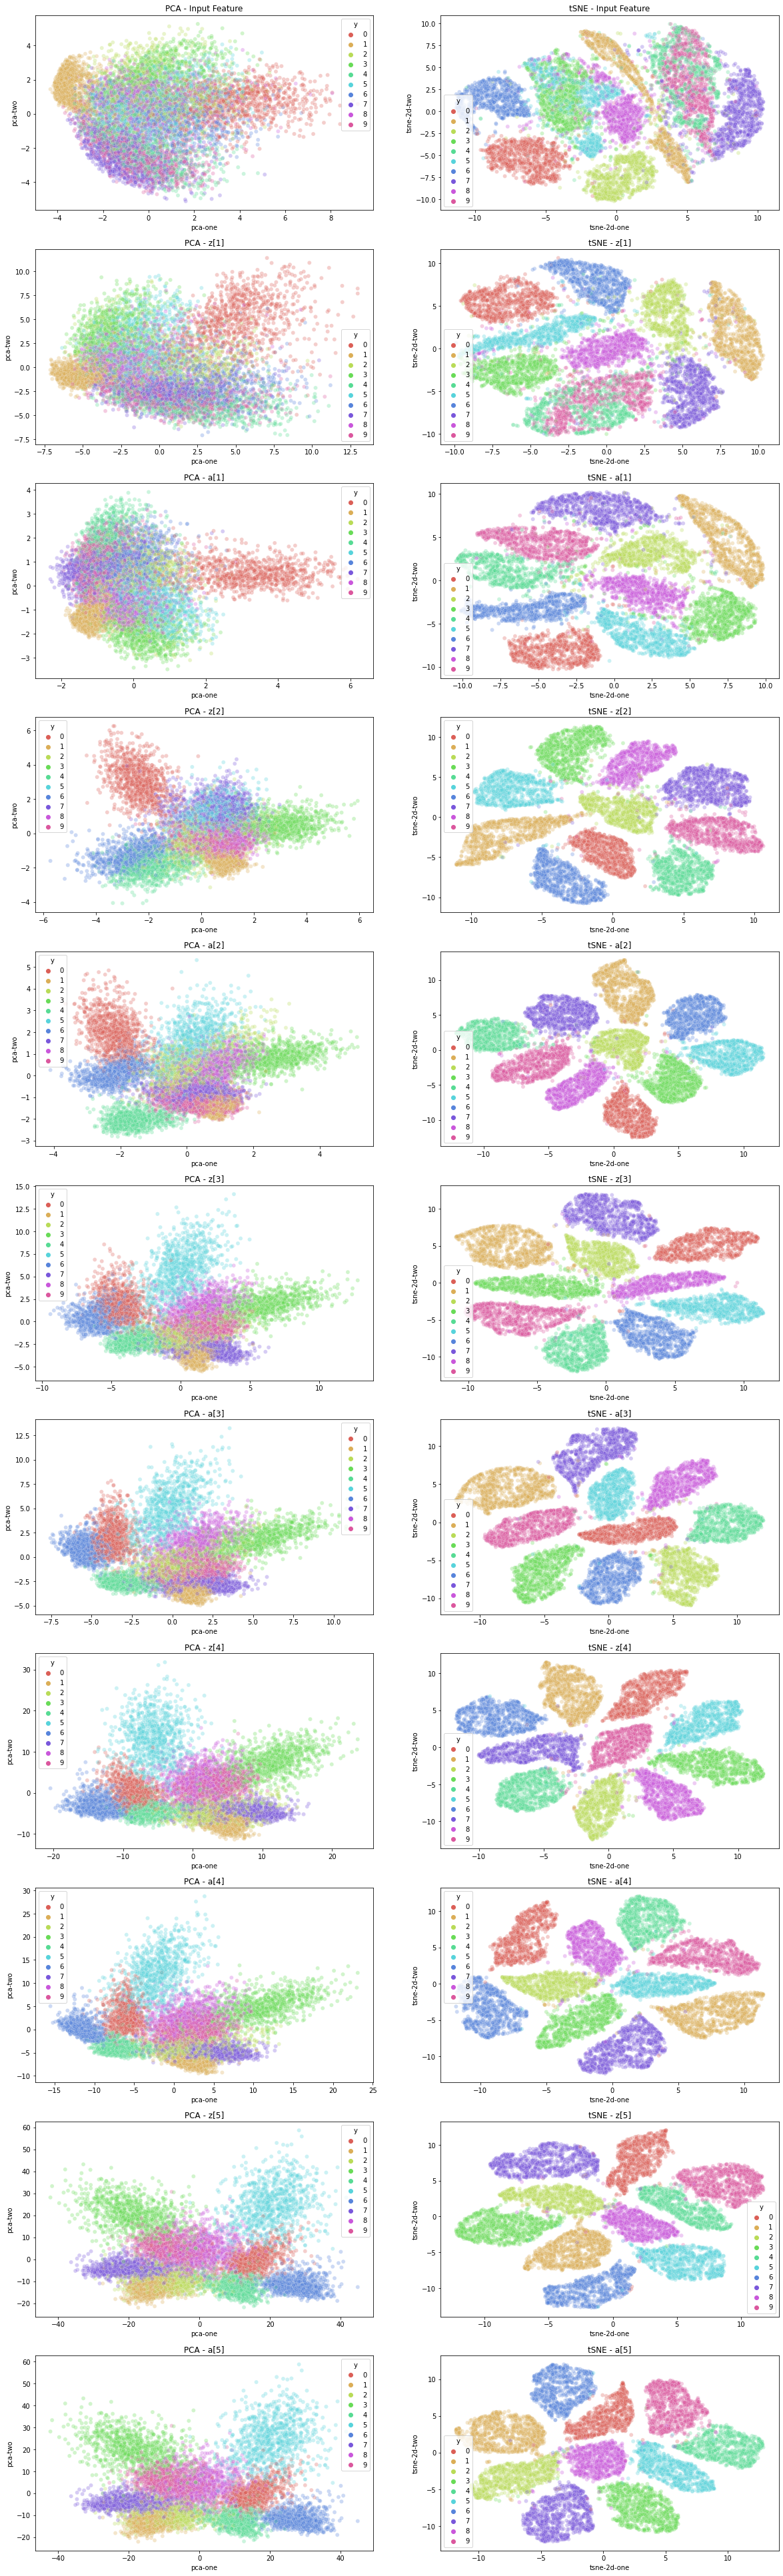

In [15]:
N = 10000
df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values

pca_result = pca.fit_transform(data_subset)
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1]
print('Explained variation per principal components: {}'.format(pca.explained_variance_ratio_))

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
print('t-SNE done! time elapsed: {} seconds'.format(time.time()-time_start))

plt.figure(figsize=(20,70))
plt.subplot(11,2,1)
plt.title("PCA - Input Feature")
set_scatterplot(df_subset["pca-one"],df_subset["pca-two"])

plt.subplot(11,2,2)
plt.title("tSNE - Input Feature")
set_scatterplot(df_subset["tsne-2d-one"],df_subset["tsne-2d-two"])

for i in range(len(output_list)) :
    df_subset = get_df(output_list[i],N)
    
    if(i % 2 == 0) :
        t = "z"
        layer_num = int(i/2 + 1)
    else :
        t = "a"
        layer_num = int((i+1)/2)
    
    plt.subplot(11,2,2*(i+1)+1)
    plt.title(f"PCA - {t}[{layer_num}]")
    set_scatterplot(df_subset["pca-one"],df_subset["pca-two"])
    
    plt.subplot(11,2,2*(i+1)+2)
    plt.title(f"tSNE - {t}[{layer_num}]")
    set_scatterplot(df_subset["tsne-2d-one"],df_subset["tsne-2d-two"])
    
plt.savefig("pca_tsne",dpi=200)